# Armageddon
## A simulation software produced by Popigai-2021

This is a simulation software for events of one spherical asteroid entering Earth atmosphere, it predicts damage zones, caused by the coming asteroid, on Earth surface. The software also produces some graphs on the interested aspects on the asteroid.

### Usage guideline

The following cell contains all the basic parameters needed to start a simulation.

- After keys in all the parameters in the cell, select 'Cell' -> 'Run Cells' in the tool bar to start a parameter check; proceed to next step if the cell outputs 'OK to proceed'; detail report is output in case of failing the parameter check

- Select 'Kernel' -> 'Restart & Run All' in the tool bar would start the simulation, then scroll down to view the outputs; some cells would take some times to produce outputs depend on the parameters given

In [22]:
## Parameter for Earth
# This set the atmospheric density profile in the simulation
#     'exponential' is default; 'tabular' gives a better simulation
atmos_func = 'exponential'

## Parameters for asteroid (at initial altitude)
# This is the initial altitude
init_altitude = 1e5
# This is the radius of the incoming asteroid (meter)
radius = 10
# This is the incoming angle of the asteroid (degree)
angle = 20
# This is the incoming velocity of the asteroid (m/s)
velocity = 19e3
# This is the density of the asteroid (kg/m^3)
density = 3000
# This is the strength of the asteroid (Pa)
strength = 1e6
# This is the entry latitude, longitude and bearing of the asteroid (degree)
entry_lat, entry_lon, bearing = 51.2, 0.7, -35.0
# This is the inital altitude of the incoming asteroid (meter)
init_altitude = 100000
# This is the out put time step you want
dt= 0.05

## Parameter about OUTPUT time-step
# This is the output time-step, the time-step used in simulation would be smaller
dt = .05

## Parameters for damage levels
# This set which level of damage is shown on a map
#     True indicates the level is shown on the map
levels = {
    'level 1': True,
    'level 2': True,
    'level 3': True,
    'level 4': True
}

## Parameter for damage mapping levels
# This set the basic level for damage mapping
#     'sector' is default, indicates infomation in the mapping is given at postcode sector level
#     'unit' means infomation given at postcode unit level
info_level = 'sector'

## Parameters to generate outputs
# set this to True to see damage mapping
see_map = False
# set this to True to see all plottings
see_plot = True

# ================== below are parameter checks ==================
if atmos_func not in ['exponential', 'tabular']:
    raise ValueError('atmos_func must be \'exponential\' or \'tabular\'')
    
if info_level not in ['sector', 'unit']:
    raise ValueError('info_level must be \'sector\' or \'unit\'')
    
if (type(levels) != dict
    or len(levels) != 4
    or list(levels.keys()) != ['level 1', 'level 2', 'level 3', 'level 4']):
    raise ValueError('only changing value is allowed for levels')
for l in levels.values():
    if type(l) != bool: raise ValueError('only boolean is allowed in levels')

for var, var_name in zip([see_map, see_plot],
                         ['see_map', 'see_plot']):
    if type(var) != bool: raise ValueError('only boolean is allowed on %s' % var_name)
        
for var, var_name in zip([init_altitude, radius, velocity, density, strength, dt],
                         ['init_altitude', 'radius', 'velocity', 'density', 'strength', 'dt']):
    if type(var) not in [int, float]: raise ValueError('%s must be a number' % var_name)
    if var <= 0: raise ValueError('%s must be a positive number' % var_name)
        
for var, var_name, var_range in zip([angle, entry_lat, entry_lon, bearing],
                                    ['angle', 'entry_latitude', 'entry_longitude', 'bearing'],
                                    [[0, 90], [-90, 90], [-180, 180], [-180, 360]]):
    if type(var) not in [int, float]: raise ValueError('%s must be a number' % var_name)
    if var < var_range[0] or var > var_range[1]:
        raise ValueError('%s must be a number between %i and %i' % (var_name, var_range[0], var_range[1]))
    
print('OK to proceed')

OK to proceed


# === CHANGE WITH CAUTION ===

This cell contains advanced parameters for the simulation, changing is allowed ONLY if you know what you are doing and these parameters WILL NOT be checked.

In [23]:
# file that contains the atmosphric pressure for 'tabular' mode
# change of file will lead to fetal error to the software
atmos_filename = 'data/AltitudeDensityTable.csv'

# some constants on Earth
# drag coefficient
Cd = 1.
# heat transfer coefficient
Ch = .1
# heat of ablation
Q = 1e7
# lift coefficient
Cl = 1e-3
# dispresion coefficient
alpha = 0.3
# radius
Rp = 6.371e6
# gravity
g = 9.81
# atmosphric scale height
H = 8000
# air density at zero altitude
rho0 = 1.2

# parameter on entry angle unit
radians = False

# pressure value for each level
pressure_levels = {
    'level 1': 1e3,
    'level 2': 3.5e3,
    'level 3': 27e3,
    'level 4': 43e3
}

# files contain postcode unit and sector level census data
postcode_file = './armageddon/resources/full_postcodes.csv'
census_file = './armageddon/resources/population_by_postcode_sector.csv'

# === DO NOT CHANGE ANYTHING IN ANY CELL BELOW ===

In [24]:
import sys

import matplotlib.pyplot as plt

import armageddon as amgd

In [25]:
planet = amgd.Planet(
    atmos_func=atmos_func, atmos_filename=atmos_filename,
    Cd=Cd, Ch=Ch, Q=Q, Cl=Cl, alpha=alpha, Rp=Rp, g=g, H=H, rho0=rho0
)

result = planet.solve_atmospheric_entry(
    radius, velocity, density, strength, angle,
    init_altitude=init_altitude, dt=dt, radians=radians
)

result = planet.calculate_energy(result)
outcome = planet.analyse_outcome(result)

In [26]:
pressures = []
for p, b in zip(pressure_levels.values(), levels.values()):
    if b: pressures.append(p)

blast_lat, blast_lon, damage_rad = amgd.damage_zones(
    outcome, lat=entry_lat, lon=entry_lon,
    bearing=bearing, pressures=pressures
)

In [27]:
locator = amgd.PostcodeLocator(
    postcode_file=postcode_file,
    census_file=census_file
)

sector = True
if info_level == 'unit': sector = False
    
if see_map:
    postcodes = locator.get_postcodes_by_radius((blast_lat, blast_lon), damage_rad, sector=sector)
    population = locator.get_population_of_postcode(postcodes, sector=sector)
    amgd.plot_results(
        entry_lat, entry_lon,
        blast_lat, blast_lon, damage_rad,
        postcodes, population, sector=sector
    )

## Following plots are simulated data about the asteroid

In [28]:
if not see_plot: raise ValueError('Stop execution since see_plot=False')
    
times = result['time']
altitude = result['altitude']

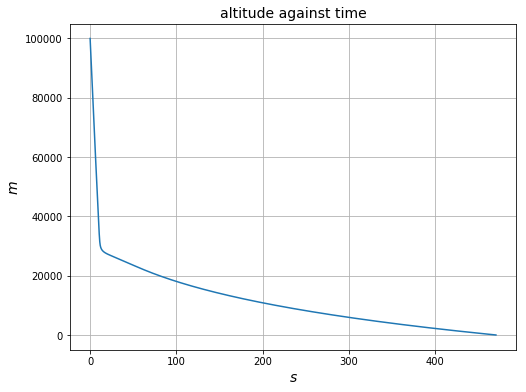

In [29]:
fig, axs = plt.subplots(figsize=(8, 6))
axs.plot(times, altitude,)
axs.set_xlabel('$s$', fontsize=14)
axs.set_ylabel('$m$', fontsize=14)
axs.set_title('altitude against time', fontsize=14)
axs.grid(True)

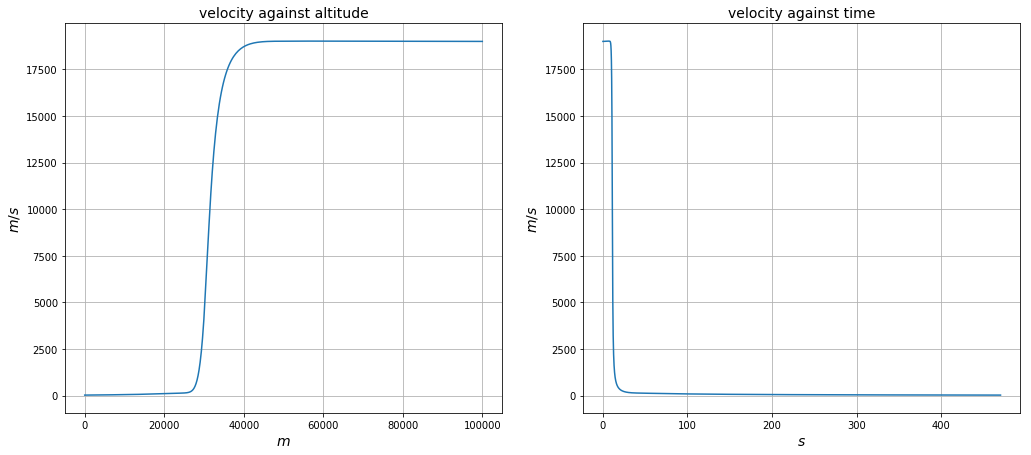

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout(w_pad=5)

axs[0].plot(altitude, result['velocity'])
axs[0].set_xlabel('$m$', fontsize=14)
axs[0].set_ylabel('$m/s$', fontsize=14)
axs[0].set_title('velocity against altitude', fontsize=14)
axs[0].grid(True)

axs[1].plot(times, result['velocity'])
axs[1].set_xlabel('$s$', fontsize=14)
axs[1].set_ylabel('$m/s$', fontsize=14)
axs[1].set_title('velocity against time', fontsize=14)
axs[1].grid(True)

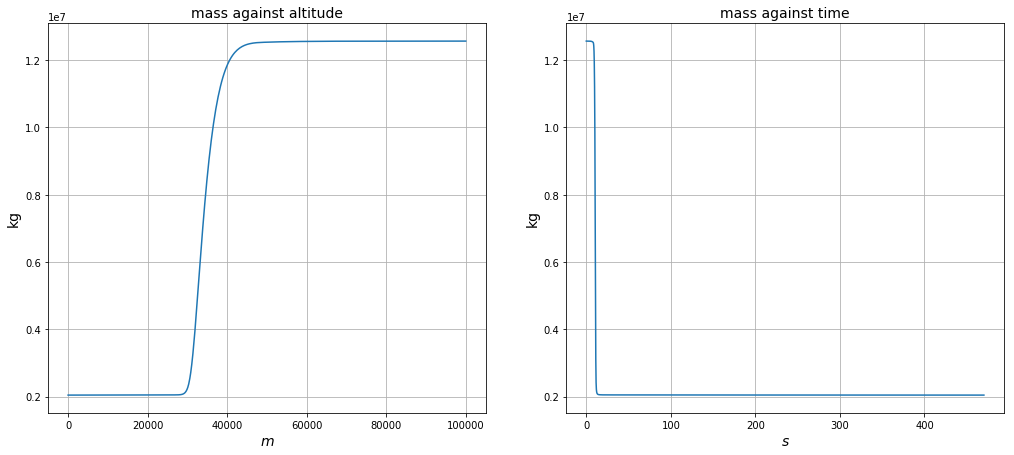

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout(w_pad=5)

axs[0].plot(altitude, result['mass'])
axs[0].set_xlabel('$m$', fontsize=14)
axs[0].set_ylabel('kg', fontsize=14)
axs[0].set_title('mass against altitude', fontsize=14)
axs[0].grid(True)

axs[1].plot(times, result['mass'])
axs[1].set_xlabel('$s$', fontsize=14)
axs[1].set_ylabel('kg', fontsize=14)
axs[1].set_title('mass against time', fontsize=14)
axs[1].grid(True)

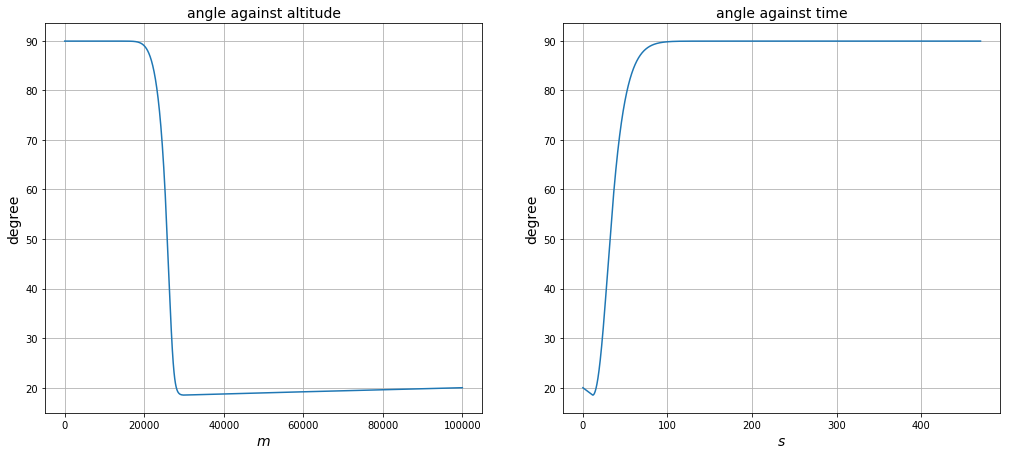

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout(w_pad=5)

axs[0].plot(altitude, result['angle'])
axs[0].set_xlabel('$m$', fontsize=14)
axs[0].set_ylabel('degree', fontsize=14)
axs[0].set_title('angle against altitude', fontsize=14)
axs[0].grid(True)

axs[1].plot(times, result['angle'])
axs[1].set_xlabel('$s$', fontsize=14)
axs[1].set_ylabel('degree', fontsize=14)
axs[1].set_title('angle against time', fontsize=14)
axs[1].grid(True)

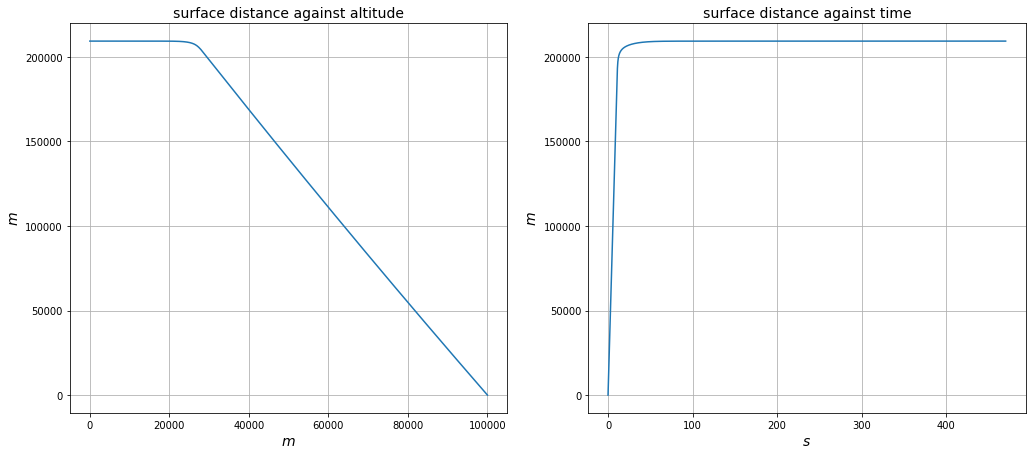

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout(w_pad=5)

axs[0].plot(altitude, result['distance'])
axs[0].set_xlabel('$m$', fontsize=14)
axs[0].set_ylabel('$m$', fontsize=14)
axs[0].set_title('surface distance against altitude', fontsize=14)
axs[0].grid(True)

axs[1].plot(times, result['distance'])
axs[1].set_xlabel('$s$', fontsize=14)
axs[1].set_ylabel('$m$', fontsize=14)
axs[1].set_title('surface distance against time', fontsize=14)
axs[1].grid(True)

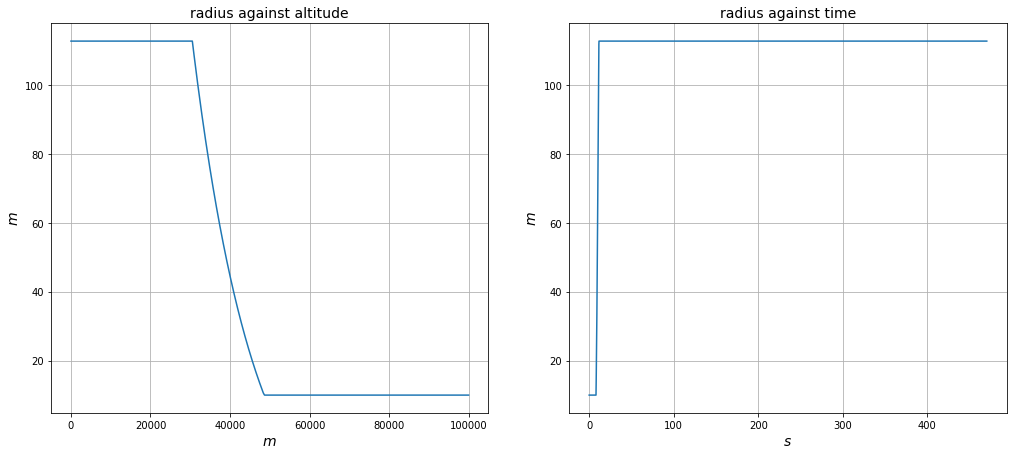

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout(w_pad=5)

axs[0].plot(altitude, result['radius'])
axs[0].set_xlabel('$m$', fontsize=14)
axs[0].set_ylabel('$m$', fontsize=14)
axs[0].set_title('radius against altitude', fontsize=14)
axs[0].grid(True)

axs[1].plot(times, result['radius'])
axs[1].set_xlabel('$s$', fontsize=14)
axs[1].set_ylabel('$m$', fontsize=14)
axs[1].set_title('radius against time', fontsize=14)
axs[1].grid(True)

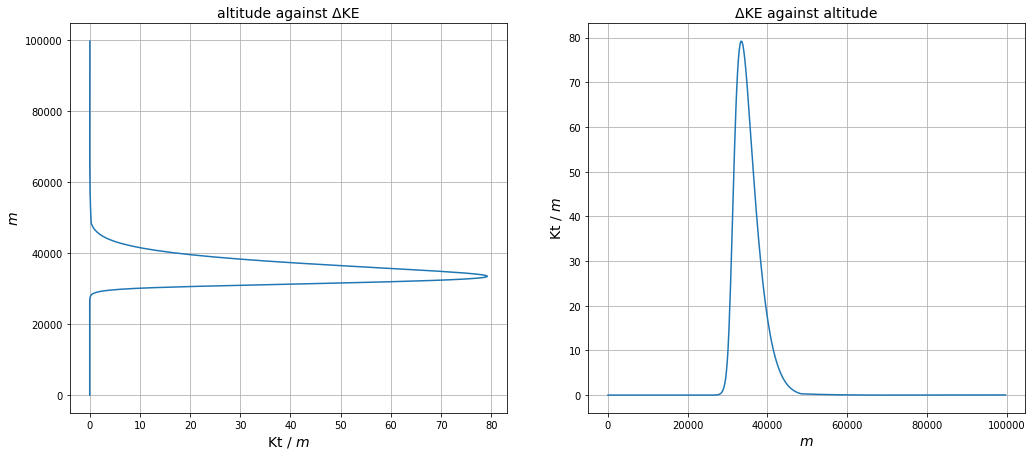

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
fig.tight_layout(w_pad=5)

axs[0].plot(result['dedz'], altitude)
axs[0].set_xlabel('Kt / $m$', fontsize=14)
axs[0].set_ylabel('$m$', fontsize=14)
axs[0].set_title('altitude against ΔKE', fontsize=14)
axs[0].grid(True)

axs[1].plot(altitude, result['dedz'])
axs[1].set_xlabel('$m$', fontsize=14)
axs[1].set_ylabel('Kt / $m$', fontsize=14)
axs[1].set_title('ΔKE against altitude', fontsize=14)
axs[1].grid(True)